## Vikas Virani (s3715555)
## Dev Bharat Doshi (s3715213)

# Predicting Payment default in the first EMI on Vehicle Loan

The objective of this project is to predict whether it will be Payment default in the first EMI on Vehicle Loan on due date or not using the Loan Default Prediction Dataset from Kaggle<cite data-cite="load_default_data">1</cite>. The original dataset came from L&T Financial Services & Analytics Vidhya presented 'DataScience FinHack' competition.  

The Kaggle Machine Learning datasets provides one data set named 'train.csv' under the heading 'Loan Default Prediction'. Names of attributes are adapted from the data description provided in Kaggle. Data set consist of 40 descriptive features and one target feature, out of which, some were dropped & some features were created in Phase-I.

This report is organized as follows:
- [Section 2 (Overview)](#2) outlines our methodology. 
- [Section 3 (Data Preparation)](#3) summarizes the data preparation process and our model evaluation strategy. 
- [Section 4 (Hyperparameter Tuning)](#4) describes the hyperparameter tuning process for each classification algorithm.
- [Section 5 (Performance Comparison)](#5) presents model performance comparison results.
- [Section 6 (Limitations)](#6) discusses a limitations of our approach and possible solutions. 
- [Section 7 (Summary)](#7) provides a brief summary of our work in this project.

Compiled from a Jupyter Notebook, this report contains both narratives and the Python code used throughout the project.

# Overview <a class="anchor" id="2"></a> 

### Methodology

We build the following binary classifiers to predict the target feature<cite data-cite="classifiers"> 2</cite>:

* K-Nearest Neighbors (KNN),
* Bagging , and
* XGBoosting (XGB)

Methodology begins by transforming the full cleaned dataset from Phase I. It includes encoding categorical descriptive features as numerical and then scaling of all the the descriptive features. We randomly sampled 20K data from dataset & split the sample into training and test sets with a 70:30 ratio and then applied Random UnderSampling Technique to recitfy imbalance in our dataset. After doing under-sampling in our dataset, our training data has around 6K rows and test data has 6K rows.

Before selecting & fitting a model, we will select the best features using the Random Forest Importance method inside our pipeline. We will consider 15, 25, and the full set of features (34 features) after encoding all the categorical features.

Using feature selection along with hyperparameter search inside a single pipeline, we will apply a 5-fold stratified cross-validation to fine-tune hyperparameters of each classifier using area under curve (AUC), Accuracy Score & Classification Report as the performance metric<cite data-cite="metrics"> 3</cite> as they give more insights on performce than others measure in general or when dataset is imbalanced. We build each model using parallel processing with "-2" cores. Since the target has more 0 values (No default) than 1 values (default) (unbalanced target class issue), stratification is important to ensure that each validation set has the same proportion of classes as in the original dataset. We will also examine sensitivity of each model with respect to its hyperparameters during the search.

Once the best model is identified for each of these three classifiers using a hyperparameter search on the training data, we will apply a 10-fold cross-validation on the test data and perform a paired t-test to see if any performance difference is statistically significant. In addition, we will compare the classifiers with respect to their recall scores and confusion matrices on the test data.

# Data Preparation <a class="anchor" id="3"></a> 

## Loading Dataset

We read dataset from the local storage. Also, since the data set contains the attribute names, we do not need to explicitly specify those during loading the data sets.

In [1]:
#pd.show_versions(as_json=False)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# set seed for reproducibility of results
np.random.seed(999)

In [2]:
Loan_Data1 = pd.read_csv('Loan_Default_Data2.csv', sep = ",")
Loan_Data1.dtypes

disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
manufacturer_id                          int64
Employment.Type                         object
State_ID                                 int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION            int64
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.SANCTIONED.AMOUNT                    int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACC

In [3]:
print(Loan_Data1.shape)

Loan_Data1.columns.values

(233154, 36)


array(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'manufacturer_id', 'Employment.Type', 'State_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS',
       'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES',
       'loan_default', 'Age', 'AvgAcctAge', 'CredAcctAge'], dtype=object)

## Checking for Missing Values

Let's make sure we do not have any missing values.

In [4]:
print('Null Counts: ')
print('')
Loan_Data1.isnull().sum()

Null Counts: 



disbursed_amount                       0
asset_cost                             0
ltv                                    0
branch_id                              0
manufacturer_id                        0
Employment.Type                        0
State_ID                               0
MobileNo_Avl_Flag                      0
Aadhar_flag                            0
PAN_flag                               0
VoterID_flag                           0
Driving_flag                           0
Passport_flag                          0
PERFORM_CNS.SCORE                      0
PERFORM_CNS.SCORE.DESCRIPTION          0
PRI.NO.OF.ACCTS                        0
PRI.ACTIVE.ACCTS                       0
PRI.OVERDUE.ACCTS                      0
PRI.CURRENT.BALANCE                    0
PRI.SANCTIONED.AMOUNT                  0
PRI.DISBURSED.AMOUNT                   0
SEC.NO.OF.ACCTS                        0
SEC.ACTIVE.ACCTS                       0
SEC.OVERDUE.ACCTS                      0
SEC.CURRENT.BALA

Let's have a look at 5 randomly selected rows in this raw dataset.

In [5]:
Loan_Data1.sample(n=5, random_state=999)

,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,Age,AvgAcctAge,CredAcctAge
93908,61947,76652,83.49,251,86,Self employed,13,1,1,1,...,0,0,0,0,0,0,1,28,0,0
48966,32734,70590,48.17,74,86,Salaried,4,1,1,0,...,0,71084,0,0,0,0,0,34,8,20
86749,65669,71946,93.13,13,86,Salaried,8,1,1,0,...,0,25991,0,1,0,2,1,34,15,36
227795,76882,122131,64.79,254,48,Self employed,13,1,0,1,...,0,0,0,0,0,0,0,40,0,0
65517,49349,69662,71.78,9,86,Self employed,3,1,1,0,...,0,1350,0,0,0,0,0,34,25,25


## Summary Statistics

The summary statistics for the full data are shown below.

In [6]:
Loan_Data1.describe(include='all')

,disbursed_amount,asset_cost,ltv,branch_id,manufacturer_id,Employment.Type,State_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,Age,AvgAcctAge,CredAcctAge
count,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154,233154.000000,233154.0,233154.00000,233154.000000,...,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Self employed,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,127635,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,54356.993528,7.586507e+04,74.746530,72.936094,69.028054,NaN,7.262243,1.0,0.84032,0.075577,...,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071,36.100946,8.915764,16.252404
std,12971.314171,1.894478e+04,11.456636,69.834995,22.141304,NaN,4.482230,0.0,0.36631,0.264320,...,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252,9.805992,15.106416,28.581255
min,13320.000000,3.700000e+04,10.030000,1.000000,45.000000,NaN,1.000000,1.0,0.00000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,47145.000000,6.571700e+04,68.880000,14.000000,48.000000,NaN,4.000000,1.0,1.00000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000
50%,53803.000000,7.094600e+04,76.800000,61.000000,86.000000,NaN,6.000000,1.0,1.00000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000
75%,60413.000000,7.920175e+04,83.670000,130.000000,86.000000,NaN,10.000000,1.0,1.00000,0.000000,...,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,43.000000,13.000000,24.000000


## Encoding Categorical Features

Before modeling, it is necessary to encode all categorical features (both the target feature and the descriptive features) into a set of numerical features.

### Encoding the Target Feature
As our Target feature is already enccoded as 1 & 0, Default & No Default, we do not need to change anything.


We will drop the unnecessary fetures from our dataset & split the dataset into Predictive features & Target feature.

In [7]:
Loan_Data = Loan_Data1.drop(columns=['loan_default','branch_id', 'manufacturer_id', 'State_ID'])
#Loan_Data = Loan_Data1.drop(columns=['loan_default'])
target = Loan_Data1['loan_default']
target.value_counts()

0    182543
1     50611
Name: loan_default, dtype: int64

### Encoding Categorical Descriptive Features
Since all of the descriptive features appear to be nominal Except from `PERFORM_CNS.SCORE.DESCRIPTION`, we perform one-hot-encoding. We only have one categorical variable which we will convert by appling the `get_dummies()` function for the regular one-hot encoding.

In [8]:
categorical_cols = Loan_Data.columns[Loan_Data.dtypes==object].tolist()

categorical_cols

['Employment.Type']

performing one-hot encoding on `Employment.Type`. `PERFORM_CNS.SCORE.DESCRIPTION` is already integer but we will not apply LabelEncoder on it.

In [9]:
Loan_Data.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'Employment.Type',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES', 'Age', 'AvgAcctAge', 'CredAcctAge'],
      dtype='object')

In [10]:
# use one-hot-encoding for categorical features with >2 levels
#Loan_Data = pd.get_dummies(Loan_Data)

from sklearn.preprocessing import LabelEncoder

#Loan_Data = Loan_Data.apply(LabelEncoder().fit_transform())
#Loan_Data.iloc[:,11] = LabelEncoder().fit_transform(Loan_Data.iloc[:,11])
Loan_Data = pd.get_dummies(Loan_Data)

After encoding, the feature set has the following columns.

In [11]:
Loan_Data.dtypes

disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION            int64
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.SANCTIONED.AMOUNT                    int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACCTS                          int64
SEC.ACTIVE.ACCTS                         int64
SEC.OVERDUE.ACCTS                        int64
SEC.CURRENT.BALANCE                      int64
SEC.SANCTIONE

In [12]:
Loan_Data.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'MobileNo_Avl_Flag',
       'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag',
       'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS',
       'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS',
       'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT',
       'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'NO.OF_INQUIRIES', 'Age',
       'AvgAcctAge', 'CredAcctAge', 'Employment.Type_Salaried',
       'Employment.Type_Self employed', 'Employment.Type_Unemployed'],
      dtype='object')

In [13]:
Loan_Data.sample(5, random_state=999)

,disbursed_amount,asset_cost,ltv,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Age,AvgAcctAge,CredAcctAge,Employment.Type_Salaried,Employment.Type_Self employed,Employment.Type_Unemployed
93908,61947,76652,83.49,1,1,1,0,0,0,0,...,0,0,0,0,28,0,0,0,1,0
48966,32734,70590,48.17,1,1,0,0,0,0,699,...,0,0,0,0,34,8,20,1,0,0
86749,65669,71946,93.13,1,1,0,0,0,0,323,...,0,1,0,2,34,15,36,1,0,0
227795,76882,122131,64.79,1,0,1,1,0,0,0,...,0,0,0,0,40,0,0,0,1,0
65517,49349,69662,71.78,1,1,0,0,0,0,763,...,0,0,0,0,34,25,25,0,1,0


## Scaling of Features

After encoding the features, we will perform a min-max scaling of all the descriptive features. Before that, we will make a copy of the Data set to keep track of column names.

In [14]:
from sklearn import preprocessing

Loan_Data_df = Loan_Data.copy()

Data_scaler = preprocessing.MinMaxScaler()
Data_scaler.fit(Loan_Data)
Loan_Data = Data_scaler.fit_transform(Loan_Data)

C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Below is a 5 sample records from dataset after performing the scaling operation. The scaler gives a `NumPy` array as an output, so we need to add column names from our copied dataset to display it into a table. We can see from below that binary features are still kept as binary after the min-max scaling.

In [15]:
pd.DataFrame(Loan_Data, columns=Loan_Data_df.columns).sample(5, random_state=999)

,disbursed_amount,asset_cost,ltv,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,Age,AvgAcctAge,CredAcctAge,Employment.Type_Salaried,Employment.Type_Self employed,Employment.Type_Unemployed
93908,0.049759,0.024907,0.864540,0.0,1.0,1.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.156863,0.000000,0.000000,0.0,1.0,0.0
48966,0.019866,0.021099,0.448864,0.0,1.0,0.0,0.0,0.0,0.0,0.785393,...,0.0,0.000000,0.0,0.000000,0.274510,0.021680,0.042735,1.0,0.0,0.0
86749,0.053568,0.021951,0.977992,0.0,1.0,0.0,0.0,0.0,0.0,0.362921,...,0.0,0.028571,0.0,0.055556,0.274510,0.040650,0.076923,1.0,0.0,0.0
227795,0.065042,0.053475,0.644463,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.392157,0.000000,0.000000,0.0,1.0,0.0
65517,0.036868,0.020516,0.726727,0.0,1.0,0.0,0.0,0.0,0.0,0.857303,...,0.0,0.000000,0.0,0.000000,0.274510,0.067751,0.053419,0.0,1.0,0.0


## Feature Selection & Ranking

We will now explore the most important 15 features as selected by Random Forest Importance (RFI) in our full dataset. This is just for a quick visualisation of the most relevant 15 features to gain some insights into completing our goal. During the hyperparameter tuning phase, we will include RFI as part of the pipeline and we will search over 15, 25, and the full set of 34 features to determine which number of features works best with each classifier.

In [16]:
from sklearn.ensemble import RandomForestClassifier

num_features = 15
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Loan_Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = Loan_Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['ltv', 'asset_cost', 'disbursed_amount', 'Age', 'CredAcctAge',
       'PRI.CURRENT.BALANCE', 'PRIMARY.INSTAL.AMT', 'PERFORM_CNS.SCORE',
       'AvgAcctAge', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT',
       'PRI.NO.OF.ACCTS', 'NO.OF_INQUIRIES', 'PRI.ACTIVE.ACCTS',
       'PERFORM_CNS.SCORE.DESCRIPTION'], dtype=object)

In [17]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.18801712, 0.18615776, 0.17671755, 0.11131461, 0.03333294,
       0.03292705, 0.03132119, 0.03106117, 0.03101349, 0.03068884,
       0.03068124, 0.01956674, 0.01369745, 0.0113691 , 0.00895797])

Let's visualize these importances by defining a function to plot the graph.

In [18]:
#Plotting feature engineering graph
def plot_importance(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    fig, ax = plt.subplots(figsize=(15,5))
    g = sns.barplot(ax=ax,x="features", y="importances", data=df)
    g.set_xticklabels(ax.get_xticklabels(),rotation=70)

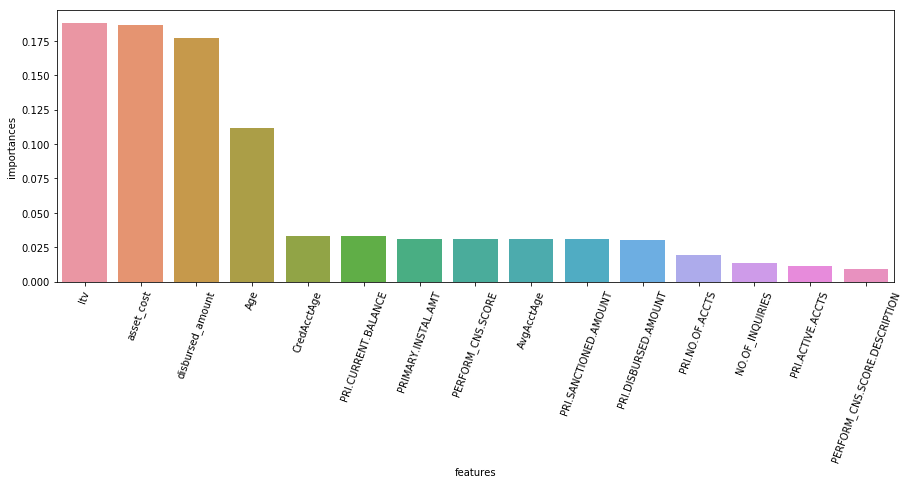

In [19]:
plot_importance(best_features_rfi, feature_importances_rfi, 'F-Score', 'red')

We observe that the most important feature is `ltv`, followed by `asset_cost`, `disbursed_amount`, and `age` and then others.

## Data Sampling & Train-Test Splitting

The original dataset has more than 230K rows, which is a lot. So, we would like to work with a small sample here with 20K rows. Thus, we will do the following:
- Randomly select 20K rows from the full dataset.
- Split this sample into train and test partitions with a 70:30 ratio using stratification.

Notable thing here is that `values` attribute is used to convert `Pandas` data frames to a `NumPy` array. You have to make absolutely sure that you **NEVER** pass `Pandas` data frames to `Scikit-Learn` functions, because it works with `NumPy` arrays, not `Pandas` data frames.

In [20]:
#Loan_Data.shape[0]
n_samples = 20000

Loan_Data_sample = pd.DataFrame(Loan_Data, columns=Loan_Data_df.columns).sample(n=n_samples, random_state=999).values
target_sample = pd.DataFrame(target, columns=['loan_default']).sample(n=n_samples, random_state=999).values

#rus = RandomUnderSampler(random_state=0)
#Loan_Data_sample, target_sample = rus.fit_sample(Loan_Data_sample, target_sample)

print(Loan_Data_sample.shape)
print(target_sample.shape)

(20000, 34)
(20000, 1)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.over_sampling import SMOTE

Data_sample_train, Data_sample_test, \
target_sample_train, target_sample_test = train_test_split(Loan_Data_sample, target_sample, 
                                                    test_size = 0.3, stratify = target_sample, random_state=786)

print('Shape of Data_sample_train :')
print(Data_sample_train.shape)
print('')
print('Shape of Data_sample_test :')
print(Data_sample_test.shape)
print('')
print('Value Counts of target_sample_train :')
print(np.unique(target_sample_train, return_counts=True))
print('')

rus = RandomUnderSampler(random_state=0)
Data_sample_train, target_sample_train = rus.fit_sample(Data_sample_train, target_sample_train)

# Handing Class imbalance
#smt = SMOTETomek(ratio='auto')
#Data_sample_train, target_sample_train = smt.fit_sample(Data_sample_train, target_sample_train)

Shape of Data_sample_train :
(14000, 34)

Shape of Data_sample_test :
(6000, 34)

Value Counts of target_sample_train :
(array([0, 1], dtype=int64), array([10947,  3053], dtype=int64))



In [22]:
print('Shape of Data_sample_train After SMOTE:')
print(Data_sample_train.shape)

Shape of Data_sample_train After SMOTE:
(6106, 34)


In [23]:
print('Value Counts of target_sample_train :')
np.unique(target_sample_train, return_counts=True)

Value Counts of target_sample_train :


(array([0, 1], dtype=int64), array([3053, 3053], dtype=int64))

In [24]:
print('Value Counts of target_sample_test :')
np.unique(target_sample_test, return_counts=True)

Value Counts of target_sample_test :


(array([0, 1], dtype=int64), array([4692, 1308], dtype=int64))

## Model Evaluation Strategy

So, we will train and tune our models on 6K rows of training data and we will test them on 6K rows of test data. 

For each model, we will use 5-fold stratified cross-validation evaluation technique (with no repetitions for shorter run times) for hyperparameter tuning.

In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score,roc_auc_score

#cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=999)
cv_method = StratifiedKFold(n_splits=5, random_state=999)

# Hyperparameter Tuning <a class="anchor" id="4"></a> 

## K-Nearest Neighbors (KNN)

Using `Pipeline`, we combine feature selection and grid search for KNN hyperparameter tuning via cross-validation. We will use the same `Pipeline` methodology for DT and NB.

The KNN hyperparameters are as follows:

* number of neighbours (`n_neighbors`) and
* the distance metric `p`
* the weight metric `weights`

For feature selection, we will use the Random Forest Importance (RFI) method with 100 estimators. To add RFI feature selection as part of the pipeline, we have defined the custom `RFIFeatureSelector()` class below to pass in RFI as a "step" to the pipeline.

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we used n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]

Instead of single scoring methos, We have used `precision_score`, `recall_score`, `accuracy_score` and `roc_auc` as parameters to GridSearch's Scoring attribute.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [15, 25, Data_sample_train.shape[1]],
                   'knn__n_neighbors': [2, 4, 8, 12, 20],
                   'knn__p': [1, 2]}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score)
}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit='roc_auc',
                           n_jobs=-2,
                           scoring=scorers,
                           verbose=1) 

In [28]:
gs_pipe_KNN.fit(Data_sample_train, target_sample_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  1.2min finished
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [29]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 20, 'knn__p': 1, 'rfi_fs__n_features_': 15}

In [30]:
gs_pipe_KNN.best_score_

0.5612512283000327

In [31]:
pred_KNN = gs_pipe_KNN.predict(Data_sample_test)

In [32]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(metrics.classification_report(target_sample_test, pred_KNN))

print(metrics.confusion_matrix(target_sample_test, pred_KNN))


              precision    recall  f1-score   support

           0       0.82      0.59      0.69      4692
           1       0.27      0.53      0.36      1308

   micro avg       0.58      0.58      0.58      6000
   macro avg       0.54      0.56      0.52      6000
weighted avg       0.70      0.58      0.62      6000

[[2776 1916]
 [ 610  698]]


We observe that the optimal KNN model has a mean AUC score of 0.56. The best performing KNN selected 15 features with 20 nearest neighbors and $p = 1$.

Even though these are the best values, we will have a look at the other combinations to see if the difference is rather significant or not. We will run a function defined below to display the grid search outputs as a data frame.

In [33]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_roc_auc"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [34]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
24,0.561241,0.013868,0.582651,0.545902,20.0,1.0,15.0
27,0.561091,0.009770,0.572131,0.545008,20.0,2.0,15.0
28,0.558779,0.022167,0.590016,0.531148,20.0,2.0,25.0
29,0.557959,0.023709,0.590835,0.527049,20.0,2.0,34.0
26,0.556162,0.020984,0.581015,0.525410,20.0,1.0,34.0


We observe that the difference between the hyperparameter combinations is not really much when conditioned on the number of features selected. Let's visualize the results of the grid search corresponding to 15 selected features.

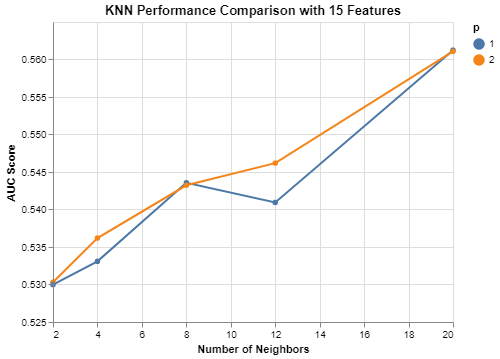

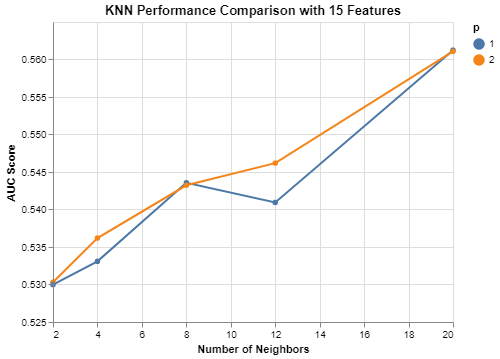

In [35]:
import altair as alt
alt.renderers.enable('notebook')

results_KNN_15_features = results_KNN[results_KNN['rfi_fs__n_features_'] == 15.0]

alt.Chart(results_KNN_15_features, 
          title='KNN Performance Comparison with 15 Features'
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Number of Neighbors'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('knn__p:N', title='p')
)

## Bagging Classifier

We build a Bagging Classifier which is a Bootsrap aggregating of multiple samples. We aim to determine the optimal value of number of estimators (`n_estimators`).

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_BG = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('bg', BaggingClassifier())])

params_pipe_BG = {'rfi_fs__n_features_': [15, 25, Data_sample_train.shape[1]],
                  'bg__n_estimators': [150, 200, 300]}

gs_pipe_BG = GridSearchCV(estimator=pipe_BG, 
                           param_grid=params_pipe_BG, 
                           cv=cv_method,
                           refit='roc_auc',
                           n_jobs=-2,
                           scoring=scorers,
                           verbose=1) 

gs_pipe_BG.fit(Data_sample_train, target_sample_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:  1.1min finished
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
gs_pipe_BG.best_params_

{'bg__n_estimators': 300, 'rfi_fs__n_features_': 15}

In [38]:
gs_pipe_BG.best_score_

0.5792662954471012

In [39]:
pred_BG = gs_pipe_BG.predict(Data_sample_test)

In [40]:
print(metrics.classification_report(target_sample_test, pred_BG))

print(metrics.confusion_matrix(target_sample_test, pred_BG))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66      4692
           1       0.26      0.58      0.36      1308

   micro avg       0.56      0.56      0.56      6000
   macro avg       0.54      0.56      0.51      6000
weighted avg       0.70      0.56      0.60      6000

[[2587 2105]
 [ 553  755]]


The best Bagging Classifier has 200 number of estimators and 34 features with an AUC score of 0.577. A visualization of the search results is given below.

In [41]:
results_BG = get_search_results(gs_pipe_BG)
results_BG.head()

,mean_score,std_score,max_score,min_score,bg__n_estimators,rfi_fs__n_features_
6,0.579261,0.008024,0.591653,0.570492,300.0,15.0
0,0.574508,0.014388,0.595745,0.559016,150.0,15.0
8,0.574014,0.015756,0.592471,0.550000,300.0,34.0
3,0.573361,0.013057,0.590016,0.557377,200.0,15.0
2,0.573361,0.013785,0.590016,0.554098,150.0,34.0


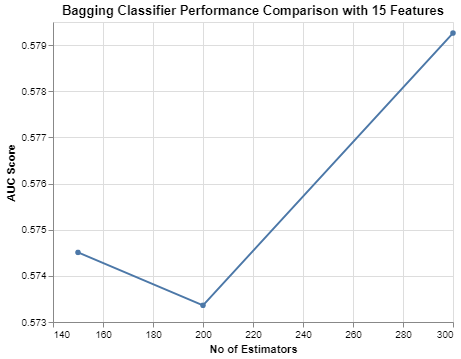

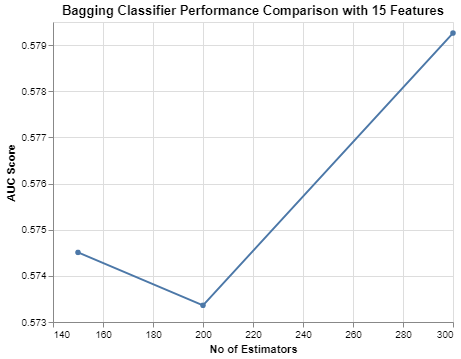

In [42]:
results_BG_15_features = results_BG[results_BG['rfi_fs__n_features_'] == 15.0]

alt.Chart(results_BG_15_features, 
          title='Bagging Classifier Performance Comparison with 15 Features'
         ).mark_line(point=True).encode(
    alt.X('bg__n_estimators', title='No of Estimators'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

### XGBoosting

We also build a XGBoosting Model. We aim to determine the optimal combinations of Number of Estimators (`n_estimators`) and Learning Rate (`learning_rate`).

In [43]:
import xgboost as xgb
from xgboost import XGBClassifier

pipe_XG = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('xg', XGBClassifier())])

params_pipe_XG = {'rfi_fs__n_features_': [15, 25, Data_sample_train.shape[1]],
                  'xg__n_estimators': [120, 140, 160, 300],
                  'xg__learning_rate': [0.06, 0.2, 0.6, 1.0]}

gs_pipe_XG = GridSearchCV(estimator=pipe_XG, 
                          param_grid=params_pipe_XG, 
                          cv=cv_method,
                          refit='roc_auc',
                          n_jobs=-2,
                          scoring=scorers,
                          verbose=1) 

gs_pipe_XG.fit(Data_sample_train, target_sample_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-2)]: Done 178 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed:  1.4min finished
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\viran\Anaconda2\envs\Python 3.6\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [44]:
gs_pipe_XG.best_params_

{'rfi_fs__n_features_': 34, 'xg__learning_rate': 0.06, 'xg__n_estimators': 300}

In [45]:
gs_pipe_XG.best_score_

0.5913855224369473

In [46]:
pred_XG = gs_pipe_XG.predict(Data_sample_test)

In [47]:
print(metrics.classification_report(target_sample_test, pred_XG))

print(metrics.confusion_matrix(target_sample_test, pred_XG))

              precision    recall  f1-score   support

           0       0.85      0.51      0.64      4692
           1       0.28      0.68      0.39      1308

   micro avg       0.55      0.55      0.55      6000
   macro avg       0.56      0.59      0.52      6000
weighted avg       0.73      0.55      0.59      6000

[[2398 2294]
 [ 423  885]]


The best XGBoosting Model has 300 Number of Estimators (`n_estimators`), 34 features and Learning Rate of 0.06 with an AUC score of 0.59. A visualization of the search results is given below.

In [48]:
results_XG = get_search_results(gs_pipe_XG)
results_XG.head()

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,xg__learning_rate,xg__n_estimators
35,0.591384,0.010925,0.610475,0.580196,34.0,0.06,300.0
19,0.590728,0.011858,0.608020,0.574468,25.0,0.06,300.0
32,0.589741,0.009812,0.601473,0.574590,34.0,0.06,120.0
34,0.589413,0.009847,0.600655,0.576230,34.0,0.06,160.0
17,0.589086,0.010446,0.604746,0.577049,25.0,0.06,140.0


Here also, the difference between the hyperparameter combinations is not really much when conditioned on the number of features selected. Let's visualize the results of the grid search corresponding to 15 selected features.

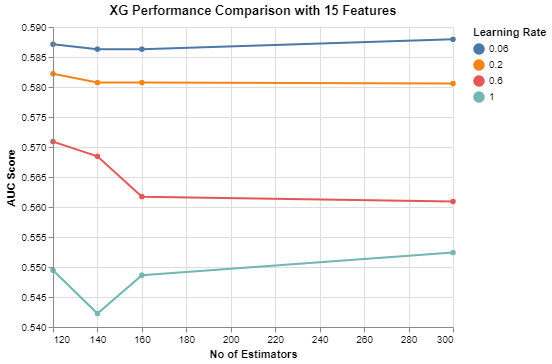

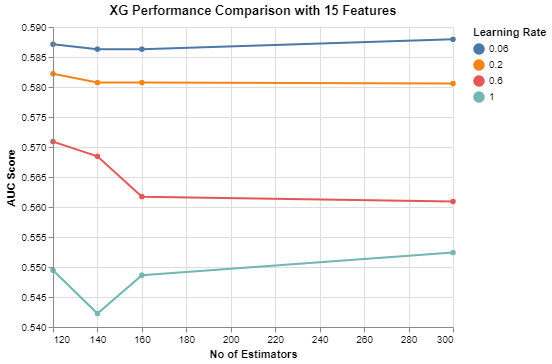

In [49]:
results_XG_15_features = results_XG[results_XG['rfi_fs__n_features_'] == 15.0]

alt.Chart(results_XG_15_features, 
          title='XG Performance Comparison with 15 Features'
         ).mark_line(point=True).encode(
    alt.X('xg__n_estimators', title='No of Estimators'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('xg__learning_rate:N', title='Learning Rate')
)

## Further Modeling

We notice that if we use **SMOTTomek instead of Random UnderSampling** when doing Resampling, We get an **AUC Score of more than 0.8** for all 3 classifiers, but the recall value for `default = true` prediction **(Target value - 1)** very less than the current models.

# Performance Comparison <a class="anchor" id="5"></a> 

We have optimized each one of the three classifiers using the **training data**. We will now fit the optimized models on the **test data** in a cross-validated fashion. We will perform pairwise t-tests to determine if any difference between the performance of any two optimized classifiers is statistically significant [1] as cross validation itself is a random process. First, we wil perform 10-fold stratified cross-validation on each best model (without any repetitions). Second, we will perform a paired t-test for the AUC score between the following model combinations:

* KNN vs. Bagging Classifier,
* KNN vs. XGBoosting, and
* XGBoosting vs. Bagging Classifier.


In [50]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=111)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=Data_sample_test,
                                 y=target_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.5714429281432499

In [51]:
cv_results_BG = cross_val_score(estimator=gs_pipe_BG.best_estimator_,
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_BG.mean()

0.5649949904405335

In [52]:
cv_results_XG = cross_val_score(estimator=gs_pipe_XG.best_estimator_,
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_XG.mean()

0.6153060354542711

Since we set the random state to be same during cross-validation, all classifiers are fitted and tested on exactly the same test data partitions. We use the `stats.ttest_rel` function from the `SciPy` module to run the following t-tests on **test data**.

In [53]:
from scipy import stats

print(stats.ttest_rel(cv_results_KNN, cv_results_BG))
print(stats.ttest_rel(cv_results_XG, cv_results_KNN))
print(stats.ttest_rel(cv_results_XG, cv_results_BG))

Ttest_relResult(statistic=0.7227559068197738, pvalue=0.4881851583364566)
Ttest_relResult(statistic=4.990186337147682, pvalue=0.0007489377561337245)
Ttest_relResult(statistic=7.918384383423829, pvalue=2.4022330568540306e-05)


A p-value smaller than 0.05 indicates a statistically significant difference. From the results of t-tests, we can conclude that at a 95% significance level, XGBoosting is statistically the best model in this competition (in terms of AUC) when compared on the **test data**. t-test between Bagging & KNN shows p-value of 0.924, which denotes that methods have almost same prediction score with KNN having slightly higher value.

Though we used AUC to optimize the algorithm hyperparameters, we shall also consider the following performance metrics to evaluate models based on the test set:

* Accuracy
* Precision
* Recall
* F1 Score (the harmonic average of precision and recall)
* Confusion Matrix

These metrics can be computed using `classification_report` from `sklearn.metrics`. The classification reports are shown below.

In [54]:
pred_KNN = gs_pipe_KNN.predict(Data_sample_test)

In [55]:
pred_BG = gs_pipe_BG.predict(Data_sample_test)

In [56]:
pred_XG = gs_pipe_XG.predict(Data_sample_test)

In [57]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_sample_test, pred_KNN))
print("\nClassification report for Bagging Classifier") 
print(metrics.classification_report(target_sample_test, pred_BG))
print("\nClassification report for XGBoosting") 
print(metrics.classification_report(target_sample_test, pred_XG))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.82      0.59      0.69      4692
           1       0.27      0.53      0.36      1308

   micro avg       0.58      0.58      0.58      6000
   macro avg       0.54      0.56      0.52      6000
weighted avg       0.70      0.58      0.62      6000


Classification report for Bagging Classifier
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      4692
           1       0.26      0.58      0.36      1308

   micro avg       0.56      0.56      0.56      6000
   macro avg       0.54      0.56      0.51      6000
weighted avg       0.70      0.56      0.60      6000


Classification report for XGBoosting
              precision    recall  f1-score   support

           0       0.85      0.51      0.64      4692
           1       0.28      0.68      0.39      1308

   micro avg       0.55      0.55      0.55      600

The confusion matrices are given below.

In [58]:
from sklearn import metrics
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_sample_test, pred_KNN))
print("\nConfusion matrix for Bagging Classifier") 
print(metrics.confusion_matrix(target_sample_test, pred_BG))
print("\nConfusion matrix for XGBoosting") 
print(metrics.confusion_matrix(target_sample_test, pred_XG))


Confusion matrix for K-Nearest Neighbor
[[2776 1916]
 [ 610  698]]

Confusion matrix for Bagging Classifier
[[2587 2105]
 [ 553  755]]

Confusion matrix for XGBoosting
[[2398 2294]
 [ 423  885]]


# Limitations and Proposed Solutions <a class="anchor" id="6"></a> 

Our modeling strategy has a few limitations. First, we have followed a black-box approach as we wanted a raw predictive performance over interpretability. In the future, we can consider a more detailed analysis on feature selection & ranking process as well as on scope of the hyperparameter spaces.

Second, we have used Random Under Sampling after splitting the data into train-test. Instead, we could have done a SMOTETomek Resampling technique to balance target feature values. Which can give different score for AUC & other performance metrics. 

Third, we have only worked with a subset of the dataset; 20K observations out of total 235K in whole dataset, for shorter run times of training and testing. As all data is important & valuable, we can re-run our modelling with the whole dataset while making sure that the train and test split is done properly with balanced target feature.

The XGBoosting classifier statistically outperforms the other two models. So, maybe we can improve it by further expanding the hyperparameters scope by including other parameters of this classification method.

# Summary <a class="anchor" id="7"></a> 

The XGBoosting classifier with all of 34 features selected by Random Forest Importance (RFI) produces the highest cross-validated AUC score on the training data. Also, when evaluated on the test set, the XGBoosting classifier again outperforms both Bagging classifier and k-Nearest Neighbor models with respect to AUC. We also noticed that our models are not very dependent on the number of features as selected by RFI when conditioned on the values of the hyperparameters in general. For this reason, it seems more preferable working with 15 features than working with the full feature set, which avoids overfitting and results in easier to train and understand models.

# References

* Kaggle Machine Learning Data Sets : Loan Default Prediction Dataset : https://www.kaggle.com/roshansharma/loan-default-prediction.

* Scikit Learn Library : https://scikit-learn.org/stable/

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

* Imbalanced-learn : https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html